Importar librerías

In [13]:
import pytorch_lightning as pl
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import random
import math

# Configuración general
DATA_DIR = "DataasetBasura/"   # tu dataset
BATCH_SIZE = 32
IMG_SIZE = (28, 28)          # reducimos tamaño para no explotar memoria
PATCH_SIZE = (7, 7)          # tamaño de patch para atención
NUM_CLASSES = 5                # CascaraManzana, EnvoltorioSnacks, Facturas, GuantesLatex, Hojas
MAX_EPOCHS = 5

# Detectar CUDA
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Entrenando en: {DEVICE}")

Entrenando en: cuda


Dataset con Patches

In [14]:
class PatchDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, patch_size=(16, 16)):
        self.dataset = dataset
        self.patch_size = patch_size

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, ix):
        image, label = self.dataset[ix]
        h, w = self.patch_size
        # Extraer patches
        patches = image.unfold(1, h, h).unfold(2, w, w)  # C x H/h x W/w x h x w
        patches = patches.contiguous().view(image.size(0), -1, h*w)  # C x N x (h*w)
        patches = patches.permute(1, 0, 2)  # N x C x (h*w)
        patches = patches.reshape(patches.size(0), -1)  # N x (C*h*w)
        return patches, label


class GarbageDataModule(pl.LightningDataModule):
    def __init__(self, data_dir=DATA_DIR, batch_size=BATCH_SIZE):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size

        self.transform = transforms.Compose([
            transforms.Resize(IMG_SIZE),
            transforms.ToTensor(),
        ])

    def setup(self, stage=None):
        full_ds = datasets.ImageFolder(self.data_dir, transform=self.transform)

        # Split train/val (80/20)
        n_total = len(full_ds)
        n_train = int(n_total * 0.8)
        n_val = n_total - n_train
        train_ds, val_ds = torch.utils.data.random_split(full_ds, [n_train, n_val])

        self.train_ds = PatchDataset(train_ds, PATCH_SIZE)
        self.val_ds = PatchDataset(val_ds, PATCH_SIZE)

        self.classes = full_ds.classes  # nombres de carpetas = clases

    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=self.batch_size)

# Crear y preparar datamodule
dm = GarbageDataModule()
dm.setup()
print("Clases:", dm.classes)


Clases: ['CascaraManzana', 'EnvoltorioSnacks', 'Facturas', 'GuantesLatex', 'Hojas']


Atención escalada y modelo

In [15]:
class ScaledDotSelfAttention(torch.nn.Module):
    def __init__(self, n_embd):
        super().__init__()
        self.key = torch.nn.Linear(n_embd, n_embd)
        self.query = torch.nn.Linear(n_embd, n_embd)
        self.value = torch.nn.Linear(n_embd, n_embd)

    def forward(self, x):
        B, L, F = x.size()
        k = self.key(x)
        q = self.query(x)
        v = self.value(x)

        att = (q @ k.transpose(1, 2)) * (1.0 / math.sqrt(k.size(-1)))
        att = torch.nn.functional.softmax(att, dim=-1)
        y = att @ v
        return y


class Model(pl.LightningModule):
    def __init__(self, patch_dim=3*PATCH_SIZE[0]*PATCH_SIZE[1],
                 seq_len=(IMG_SIZE[0]//PATCH_SIZE[0])*(IMG_SIZE[1]//PATCH_SIZE[1]),
                 num_classes=NUM_CLASSES):
        super().__init__()
        self.attn = ScaledDotSelfAttention(patch_dim)
        self.actn = torch.nn.ReLU(inplace=True)
        self.fc = torch.nn.Linear(patch_dim*seq_len, num_classes)

    def forward(self, x):
        x = self.attn(x)
        y = self.fc(self.actn(x.view(x.size(0), -1)))
        return y

    def predict(self, x):
        with torch.no_grad():
            y_hat = self(x)
            return torch.argmax(y_hat, axis=1)

    def compute_loss_and_acc(self, batch):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = (torch.argmax(y_hat, axis=1) == y).sum().item() / y.shape[0]
        return loss, acc

    def training_step(self, batch, batch_idx):
        loss, acc = self.compute_loss_and_acc(batch)
        self.log('loss', loss)
        self.log('acc', acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, acc = self.compute_loss_and_acc(batch)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.003)


Entrenamiento

In [16]:
model = Model()

trainer = pl.Trainer(
    max_epochs=MAX_EPOCHS,
    accelerator="gpu" if DEVICE == "cuda" else "cpu",
    devices=1,
    logger=None
)

trainer.fit(model, dm)


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type                   | Params | Mode 
--------------------------------------------------------
0 | attn | ScaledDotSelfAttention | 65.3 K | train
1 | actn | ReLU                   | 0      | train
2 | fc   | Linear                 | 11.8 K | train
--------------------------------------------------------
77.0 K    Trainable params
0         Non-trainable params
77.0 K    Total params
0.308     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 4: 100%|██████████| 1274/1274 [13:43<00:00,  1.55it/s, v_num=4, acc=0.900, val_loss=0.563, val_acc=0.804]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1274/1274 [13:43<00:00,  1.55it/s, v_num=4, acc=0.900, val_loss=0.563, val_acc=0.804]


Visualización de predicciones

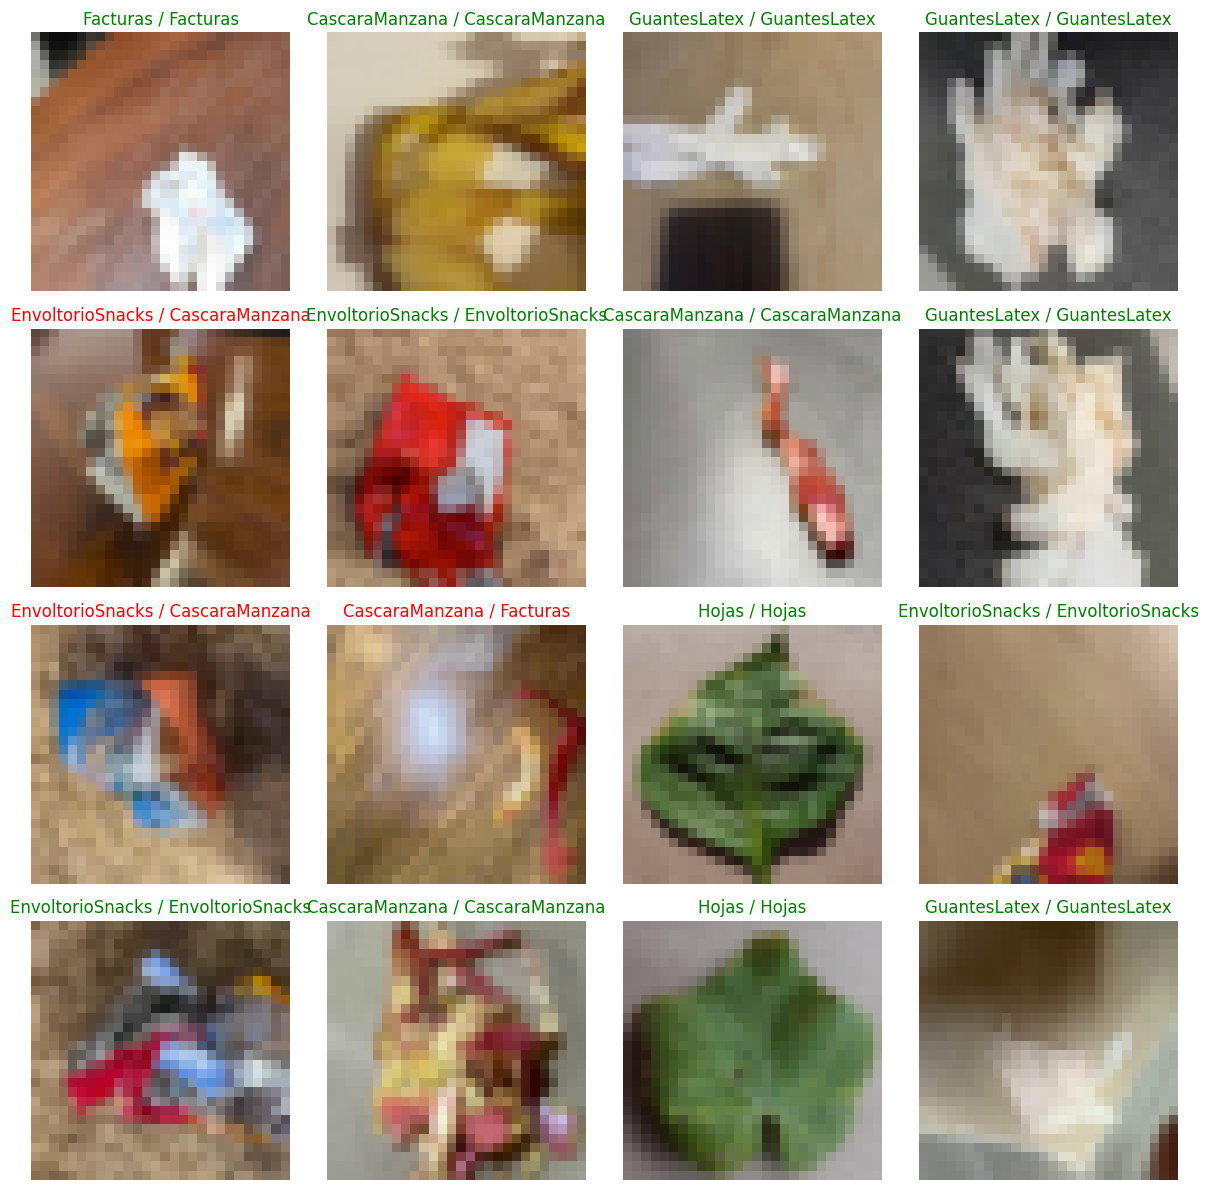

In [18]:
imgs, labels = next(iter(dm.val_dataloader()))
preds = model.predict(imgs.to(model.device))

r, c = 4, 4
fig = plt.figure(figsize=(c*3, r*3))
for i in range(r):
    for j in range(c):
        ix = i*c + j
        ax = plt.subplot(r, c, ix + 1)

        # reconstruir imagen original (no patches)
        img, label = dm.val_ds.dataset[ix]
        ax.imshow(img.permute(1, 2, 0))  # C,H,W -> H,W,C
        ax.axis("off")

        pred_label = preds[ix].item()
        true_label = labels[ix].item()
        color = "green" if pred_label == true_label else "red"
        ax.set_title(f'{dm.classes[true_label]} / {dm.classes[pred_label]}', color=color)

plt.tight_layout()
plt.show()
